In [1]:
%env CUDA_VISIBLE_DEVICES=6

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import sys
sys.path.append('../..')
from contrib.DMI.SST.data import *
from contrib.DMI.SST.load_data import *
from src.utils import *
from src.models import *


import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66
datamodule = BaseDataModule_wcoarse_wgeo(input_da=load_data_wcoarse_wgeo(path_obs="/Odyssey/private/m19beauc/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",
                                                      path_tgt="/Odyssey/private/m19beauc/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC.nc",     
                                                      path_oi="/Odyssey/private/m19beauc/DMI/training_dataset/DMI-L4_GHRSST-SSTfnd-DMI_OI-NSEABALTIC.nc",
                                                      path_coarse="/Odyssey/private/m19beauc/DMI/training_dataset/DMI-L3S_GHRSST-SSTsubskin-night_SST_UHR_NRT-NSEABALTIC_w4DVarNet_coarse.nc",
                                                      path_topo="/Odyssey/private/m19beauc/DMI/training_dataset/DMI-TOPO_NSEABALTIC.nc",
                                                      path_fgstd="/Odyssey/private/m19beauc/DMI/training_dataset/DMI-FGSTD_NSEABALTIC.nc"),
                            domains={'train': {'time': slice('2019-05-01', '2020-12-31',)},
                                     'val': {'time': [ slice('2021-01-01', '2021-01-31',),
                                                       slice('2021-04-01', '2021-04-30',),
                                                       slice('2021-07-01', '2021-07-31',),
                                                       slice('2021-10-01', '2021-10-31',) ]},
                                     'test': {'time': slice('2021-06-01', '2021-06-30',)}},
                            xrds_kw={'patch_dims': {'time': 7, 'lat': 240, 'lon': 240},
                                     'strides': {'time': 1, 'lat': 5, 'lon': 5},
                                     'strides_test': {'time': 1, 'lat': 200, 'lon': 200},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,)),
                                     },
                            dl_kw={'batch_size': 2, 'num_workers': 0},
                            res=0.02,
                            pads=[False,False,True],
                            norm_stats =[-0.015420883207237286,0.4562528584789277])
datamodule.setup()
data_loader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()

/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/homes/m19beauc/4dvarnet-starter/Notebooks/Notebook_DMI/../../contrib/DMI/SST/load_data.py:83: RuntimeWarning: invalid value encountered in log
  'topo':(('lat','lon'),np.log(-1.*topo.topo.data+1)),
/homes/m19beauc/4dvarnet-starter/Notebooks/Notebook_DMI/../../contrib/DMI/SST/data.py:139: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  da_dims = dict(zip(self.da.dims.keys(), self.da.dims.values()))


# 1. Display the patch strategy

## 1.1 Plot the training batches

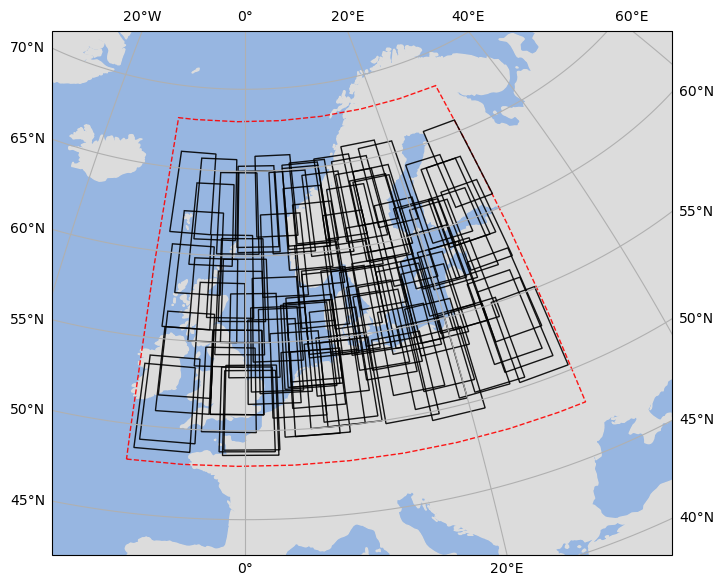

In [3]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import sample 

map_proj = ccrs.Orthographic(0, 45)
map_proj._threshold /= 100.

fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-15, 35, 43, 71], crs=ccrs.PlateCarree())
lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66

coords = datamodule.train_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[lon_min, lat_min], width=40, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.9,
                                    facecolor="none",
                                    transform=ccrs.PlateCarree()))

for i in range(0,100):
    # test1
    ax.add_patch(mpatches.Rectangle(xy=[coords[i].lon[0], coords[i].lat[0]], 
                                    width=datamodule.xrds_kw['patch_dims']['lon']*0.02,
                                    height=datamodule.xrds_kw['patch_dims']['lat']*0.02,
                                    edgecolor='black',
                                    facecolor="none",
                                    alpha=0.9,
                                    transform=ccrs.PlateCarree()))      
plt.show()

## 1.2 Plot the testing batches

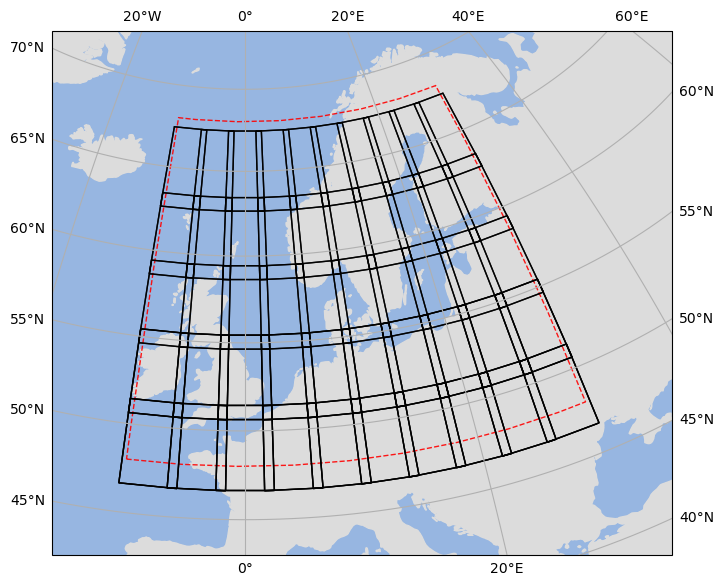

In [4]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro', zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-15, 35, 43, 71], crs=ccrs.PlateCarree())
lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66

coords = datamodule.test_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[lon_min, lat_min], width=40, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.9,
                                    facecolor="none",
                                    transform=ccrs.PlateCarree()))

for i in range(120):
    ax.add_patch(mpatches.Rectangle(xy=[coords[i].lon[0], coords[i].lat[0]],
                                    width=datamodule.xrds_kw['patch_dims']['lon']*0.02,
                                    height=datamodule.xrds_kw['patch_dims']['lat']*0.02,
                                    edgecolor='black',
                                    facecolor="none",
                                    alpha=0.9,
                                    transform=ccrs.PlateCarree()))        

## 1.3 Plot the areas of interest

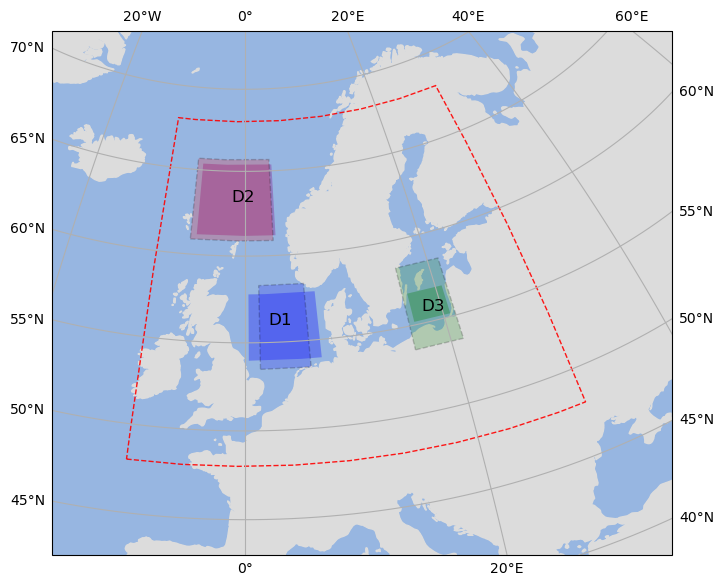

In [5]:
fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, color='gainsboro',zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-15, 35, 43, 71], crs=ccrs.PlateCarree())
lon_min = -10
lon_max = 30
lat_min = 48
lat_max = 66

coords = datamodule.test_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[lon_min, lat_min], width=40, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.9,
                                    facecolor="none",
                                    transform=ccrs.PlateCarree()))

# Domain #1
ax.add_patch(mpatches.Rectangle(xy=[0.38,53.98], width=7, height=3.8,
                                    facecolor='blue',
                                    alpha=0.3,
                                    transform=ccrs.PlateCarree()))  
ax.text(0.38+2, 53.98+2, "D1", fontsize=12,transform=ccrs.PlateCarree())
# training_DM1 (lon:[1.48,6.28], lat:[53.48,58.28])
ax.add_patch(mpatches.Rectangle(xy=[1.48,53.48], width=4.8, height=4.8,
                                    facecolor='blue',
                                    linestyle="dashed",
                                    edgecolor='black',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))  
                                    
# Domain #2
ax.add_patch(mpatches.Rectangle(xy=[-5.62,61.18], width=9.2, height=4.2,
                                    facecolor='purple',
                                    alpha=0.3,
                                    transform=ccrs.PlateCarree()))
ax.text(-5.62+4, 61.18+2, "D2", fontsize=12,transform=ccrs.PlateCarree())
# training_DM2 (lon:[-6.32,3,28], lat:[60.88,65.68])
ax.add_patch(mpatches.Rectangle(xy=[-6.32,60.88], width=9.6, height=4.8,
                                    facecolor='red',
                                    linestyle="dashed",
                                    edgecolor='black',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))


# Domain #3
ax.add_patch(mpatches.Rectangle(xy=[16.94,55.18], width=3.74, height=1.66,
                                    facecolor='green',
                                    alpha=0.3,
                                    transform=ccrs.PlateCarree())) 
ax.text(16.94+1, 55.18+.5, "D3", fontsize=12,transform=ccrs.PlateCarree())
# training_DM3 (lon:[16.41,21.21], lat:[53.61,58.41])
ax.add_patch(mpatches.Rectangle(xy=[16.41,53.61], width=4.8, height=4.8,
                                    facecolor='green',
                                    linestyle="dashed",
                                    edgecolor='black',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))  

# 2. Load the model and run

In [3]:
device = 'cuda'

from contrib.DMI.SST.solver_VAE import *

class GradSolver_VAE(nn.Module):

    def __init__(self, obs_cost, gen_mod, grad_mod, n_step, lr_grad=0.2, latent = True, **kwargs):
        super().__init__()

        # Need 3 models (obs, gen(anom), solver-J) )
        self.obs_cost = obs_cost
        self.gen_mod = gen_mod
        self.grad_mod = grad_mod
        self.latent = latent
        self.n_step = n_step
        self.lr_grad = lr_grad
        self.lambda_obs = torch.nn.Parameter(torch.Tensor([1.]))
        self.lambda_reg = torch.nn.Parameter(torch.Tensor([1.]))

        self._grad_norm = None

    def init_state(self, batch, x_init=None):
        if x_init is None:
            x_init = batch.input.nan_to_num().detach().requires_grad_(True)
        coords_cov = torch.stack((batch.latv[:,0].nan_to_num(),
                                  batch.lonv[:,0].nan_to_num(),
                                  batch.land_mask[:,0].nan_to_num(),
                                  batch.topo[:,0].nan_to_num(),
                                  batch.fg_std[:,0].nan_to_num()), dim=1).to(x_init.device)
        x_aug = torch.cat((x_init, coords_cov),dim=1)
        z = self.gen_mod.encoder(x_aug)[0]
        x_init = self.gen_mod.decoder(z)
        #x_init = torch.where(torch.isnan(batch.input),x_init,batch.input)

        return (x_init, coords_cov)

    def solver_step(self, state, batch, step):
        # ! in this setup:
        # x is the anom x_HR-x_LR

        # full state
        x, coords_cov = state

        # assimilation is done in latent space
        x_aug = torch.cat((x, state[1]),dim=1)

        if self.latent:
            z = self.gen_mod.encoder(x_aug)[0]
            var_cost = self.lambda_reg**2 * torch.norm(z) + self.lambda_obs**2 * self.obs_cost(x, batch)
            grad = torch.autograd.grad(var_cost, z, create_graph=True)[0]
            gmod = self.grad_mod(grad)
            z_update = ( 1 / (step + 1) * gmod + self.lr_grad * (step + 1) / self.n_step * grad)
            x = self.gen_mod.decoder(z - z_update)
            #x = torch.where(batch.input==0,x,batch.input)
        else:
            var_cost = self.lambda_reg**2 * torch.norm(x) + self.lambda_obs**2 * self.obs_cost(x, batch)
            grad = torch.autograd.grad(var_cost, x, create_graph=True)[0]
            gmod = self.grad_mod(grad)
            x_update = ( 1 / (step + 1) * gmod + self.lr_grad * (step + 1) / self.n_step * grad)
            x = x - x_update

        state = (x, coords_cov)

        return state

    def forward(self, batch):
        with torch.set_grad_enabled(True):
            state = self.init_state(batch)
            if self.latent:
                self.grad_mod.reset_state(self.gen_mod.encoder(torch.cat(state,dim=1))[0])
            else:
                self.grad_mod.reset_state(batch.input)

            states = []
            for step in range(self.n_step):
                state = self.solver_step(state, batch, step=step)
                if not self.training:
                    state = [s.detach().requires_grad_(True) for s in state]
                states.append(state[0])

            """
            if not self.training:
                 x = state[0]
                 z = self.gen_mod.project_latent_space(x)
                 x = self.gen_mod.decoder(z)
                 state = (x, state[1])
            """
        return state[0], states

In [6]:
from contrib.DMI.SST.VAE import VAE

# state only
solver_VAE = GradSolver_VAE(n_step=15,
                            lr_grad=1e3,
                            latent=False,
                            obs_cost = BaseObsCost(),
                            gen_mod = VAE(in_channels=12,
                                          out_channels=50,
                                          path_weights="/homes/m19beauc/4dvarnet-starter/ckpt/DMI/SST/ckpt_vae_dmi.pth"),
                            grad_mod = ConvLstmGradModel(dim_in=7,dim_hidden=96)).to(device)

## 2.1 Define the parameters (anom)

In [7]:
from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

rec_weight = get_last_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 20, 'lon': 20}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)

optim_weight = get_linear_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time'],
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 20, 'lon': 20}, offset=1)
optim_weight = torch.from_numpy(optim_weight).to(device)

def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.05:
        return None, None

    loss, out = base_step(batch)
    
    grad_loss = weighted_mse(kfilts.sobel(out) - kfilts.sobel(batch.tgt), optim_weight)
    training_loss = 50*loss  + 1000 * grad_loss 
    print(50*loss, 1000 * grad_loss)
    
    return training_loss, out

def base_step(batch):

    out, _ = solver_VAE(batch=batch)
    # mse loss
    loss = weighted_mse(out - batch.tgt, optim_weight)
    return loss, out
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

In [9]:
ckpt = torch.load('/homes/m19beauc/4dvarnet-starter/ckpt/DMI/SST/sst_dmi_baltic_wcoarse_wgeo_wvae.ckpt', map_location=device)
solver_weights = {k[7:]: v for k, v in ckpt["state_dict"].items() if k.startswith("solver.")}
solver_VAE.load_state_dict(solver_weights)

<All keys matched successfully>

# 2.2 VAE priors

In [10]:
k=30
test_batch = next(itertools.islice(test_dataloader, k, None))
test_batch_ = test_batch
test_batch_ = test_batch_._replace(input=test_batch_.input.to(device))
test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.to(device))
test_batch_ = test_batch_._replace(topo=torch.zeros(test_batch_.topo.size()))
# plot VAE  
x_aug = torch.cat(solver_VAE.init_state(test_batch_),dim=1)
latent = solver_VAE.gen_mod.encoder(x_aug)[0]
latent.shape

torch.Size([2, 25, 30, 30])

### 2.2.1 Display latent space

/tmp/ipykernel_3993103/3311312353.py:25: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_3993103/3311312353.py:31: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


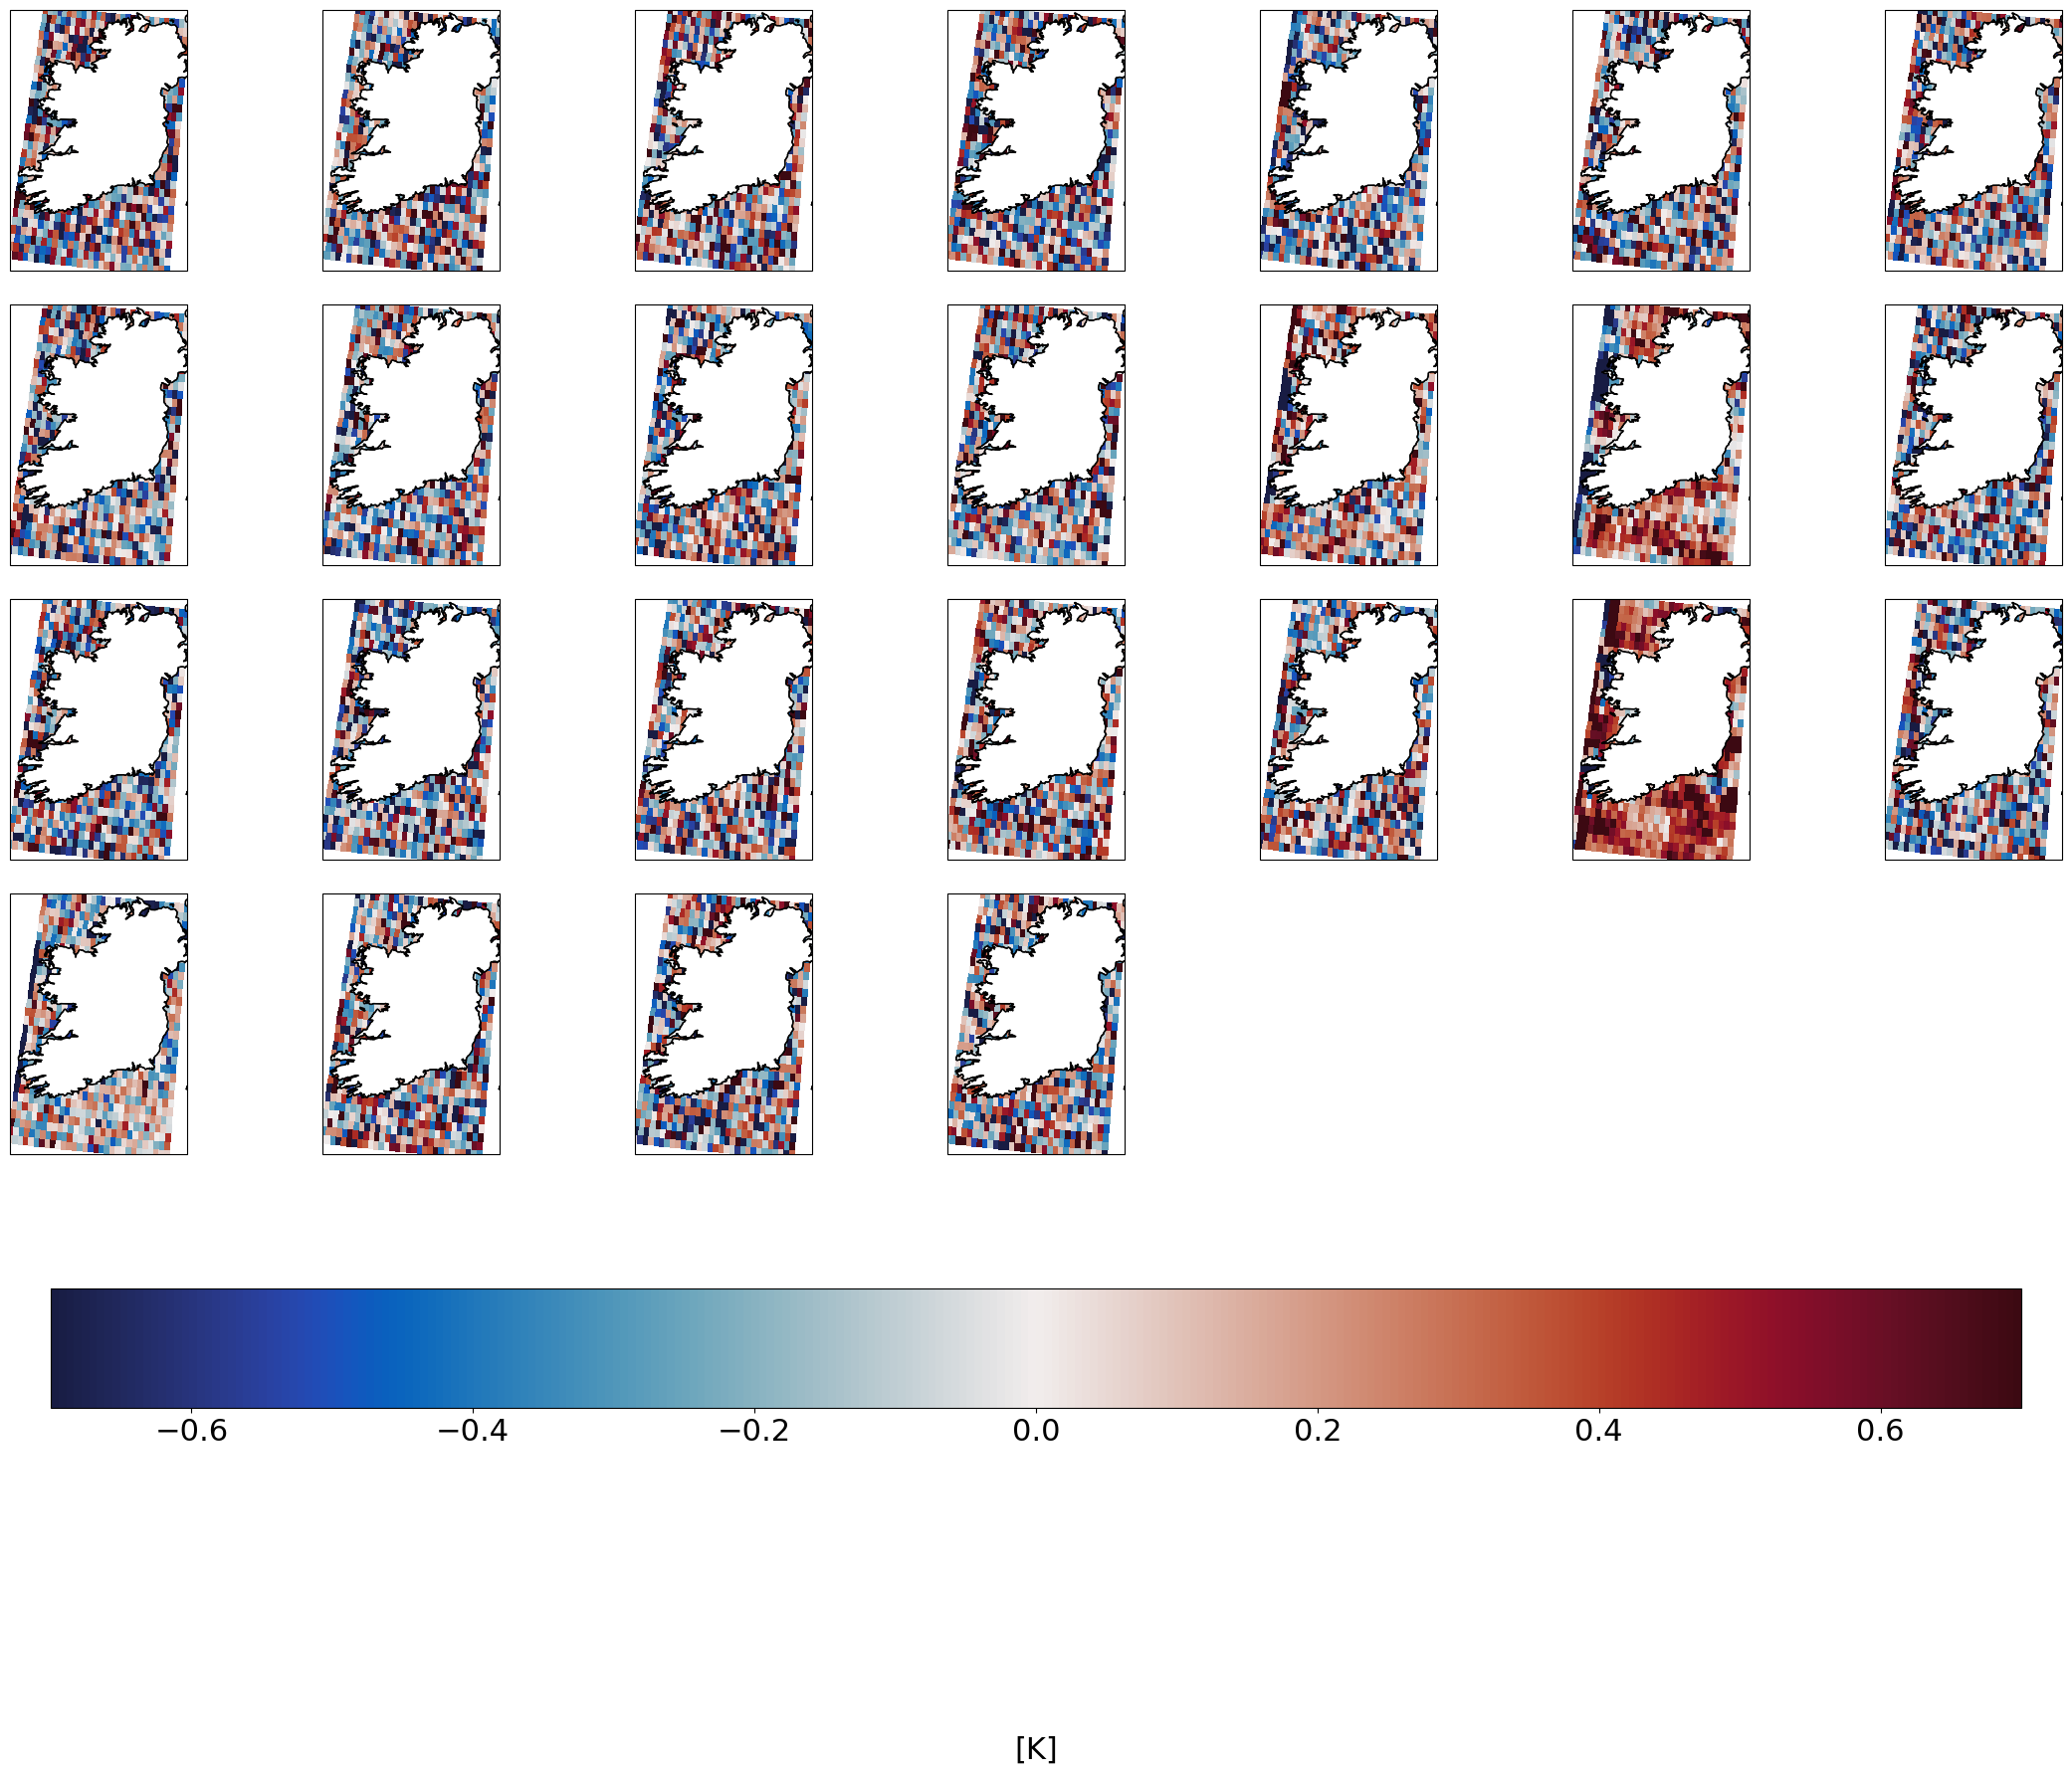

In [13]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import sample 
import cmocean as cmo

map_proj = ccrs.Orthographic(0, 45)
map_proj._threshold /= 100.
coords = datamodule.test_ds.get_coords()
m, s = [-0.015420883207237286,0.4562528584789277]
# datamodule.train_ds[0].input has shape (15, 240, 240)
#plt.figure(figsize=(30,20))
p = xr.Dataset(data_vars={'sst':(('time','lat','lon'),latent[0,:,:,:].detach().cpu().numpy()*s+m)},
           coords={'time':np.arange(25),
                   'lon':coords[2*k].lon[0::8],
                   'lat':coords[2*k].lat[0::8]}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='time',col_wrap=7,
                                                   vmin=-.7, vmax=.7,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)
mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-3)

for ax in p.axes.flat:
    ax.set_title('')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    #ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon[0::8]), 
                   np.max(coords[2*k].lon[0::8]), 
                   np.min(coords[2*k].lat[0::8]), 
                   np.max(coords[2*k].lat[0::8])], crs=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1)

### 2.2.3 Display batches (same obs ,different covariates)

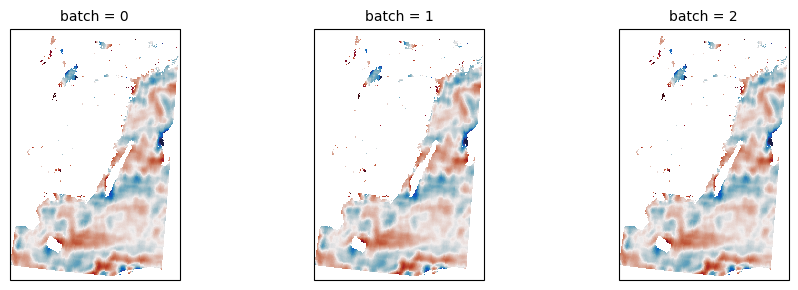

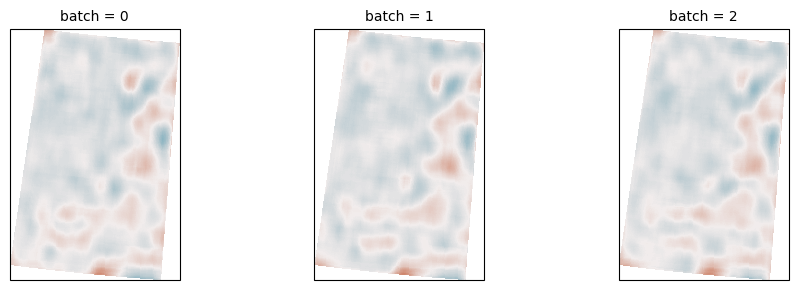

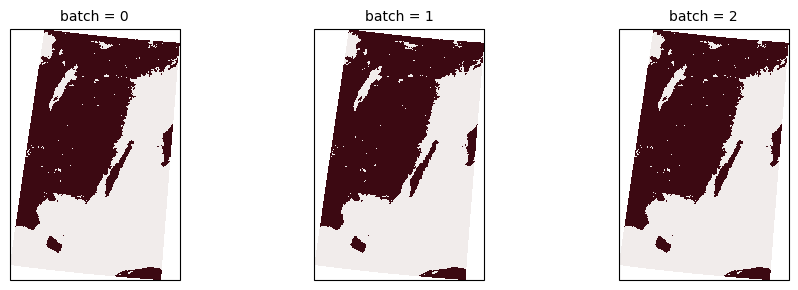

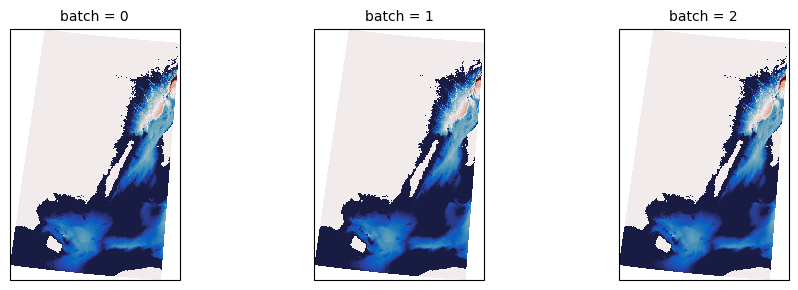

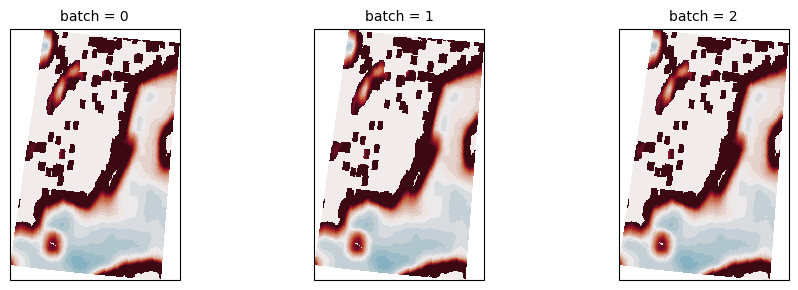

In [16]:
import random 
random.seed(42)
batch1 = next(itertools.islice(test_dataloader, 13, None))
batch1 = batch1._replace(input=batch1.input.to(device))
batch1 = batch1._replace(tgt=batch1.tgt.to(device))
x_aug = torch.cat(solver_VAE.init_state(batch1),dim=1)
prior1 = solver_VAE.gen_mod.decoder(solver_VAE.gen_mod.encoder(x_aug)[0])
prior2 = solver_VAE.gen_mod.decoder(solver_VAE.gen_mod.encoder(x_aug)[0])
prior3 = solver_VAE.gen_mod.decoder(solver_VAE.gen_mod.encoder(x_aug)[0])
batch2 = batch1
batch3 = batch1

"""
batch2 = next(itertools.islice(test_dataloader, 42, None))
batch2 = batch2._replace(input=batch1.input.to(device))
batch2 = batch2._replace(tgt=batch1.tgt.to(device))
x_aug = torch.cat(solver_VAE.init_state(batch2),dim=1)
prior2 = solver_VAE.gen_mod.decoder(solver_VAE.gen_mod.encoder(x_aug)[0])

batch3 = next(itertools.islice(test_dataloader, 37, None))
batch3 = batch3._replace(input=batch1.input.to(device))
batch3 = batch3._replace(tgt=batch1.tgt.to(device))
x_aug = torch.cat(solver_VAE.init_state(batch3),dim=1)
prior3 = solver_VAE.gen_mod.decoder(solver_VAE.gen_mod.encoder(x_aug)[0])
"""

p = xr.Dataset(data_vars={'sst':(('batch','lat','lon'),
                        np.stack((batch1.input[0,6,:,:].detach().cpu().numpy()*s+m,
                                  batch2.input[0,6,:,:].detach().cpu().numpy()*s+m,
                                  batch3.input[0,6,:,:].detach().cpu().numpy()*s+m),axis=0))},
           coords={'batch':np.arange(3),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='batch',col_wrap=3,
                                                   vmin=-.7, vmax=.7,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)

p = xr.Dataset(data_vars={'sst':(('batch','lat','lon'),
                        np.stack((prior1[0,6,:,:].detach().cpu().numpy()*s+m,
                                  prior2[0,6,:,:].detach().cpu().numpy()*s+m,
                                  prior3[0,6,:,:].detach().cpu().numpy()*s+m),axis=0))},
           coords={'batch':np.arange(3),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='batch',col_wrap=3,
                                                   vmin=-.7, vmax=.7,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)

p = xr.Dataset(data_vars={'sst':(('batch','lat','lon'),
                        np.stack((torch.cat(solver_VAE.init_state(batch1),dim=1)[0,9,:,:].detach().cpu().numpy(),
                                  torch.cat(solver_VAE.init_state(batch2),dim=1)[0,9,:,:].detach().cpu().numpy(),
                                  torch.cat(solver_VAE.init_state(batch3),dim=1)[0,9,:,:].detach().cpu().numpy()),axis=0))},
           coords={'batch':np.arange(3),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='batch',col_wrap=3,
                                                   vmin=-.7, vmax=.7,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)

p = xr.Dataset(data_vars={'sst':(('batch','lat','lon'),
                        np.stack((torch.cat(solver_VAE.init_state(batch1),dim=1)[0,10,:,:].detach().cpu().numpy(),
                                  torch.cat(solver_VAE.init_state(batch2),dim=1)[0,10,:,:].detach().cpu().numpy(),
                                  torch.cat(solver_VAE.init_state(batch3),dim=1)[0,10,:,:].detach().cpu().numpy()),axis=0))},
           coords={'batch':np.arange(3),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='batch',col_wrap=3,
                                                   vmin=-.7, vmax=.7,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)

p = xr.Dataset(data_vars={'sst':(('batch','lat','lon'),
                        np.stack((torch.cat(solver_VAE.init_state(batch1),dim=1)[0,11,:,:].detach().cpu().numpy(),
                                  torch.cat(solver_VAE.init_state(batch2),dim=1)[0,11,:,:].detach().cpu().numpy(),
                                  torch.cat(solver_VAE.init_state(batch3),dim=1)[0,11,:,:].detach().cpu().numpy()),axis=0))},
           coords={'batch':np.arange(3),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='batch',col_wrap=3,
                                                   vmin=-.7, vmax=.7,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)

# 2.3 Solver

In [ ]:
k=30
test_batch = next(itertools.islice(test_dataloader, k, None))
test_batch_ = test_batch
test_batch_ = test_batch_._replace(input=test_batch_.input.to(device))
test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.to(device))
# 4DVarNets scheme  
out = solver_VAE(test_batch_)

/tmp/ipykernel_2610785/2766902297.py:19: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_2610785/2766902297.py:25: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


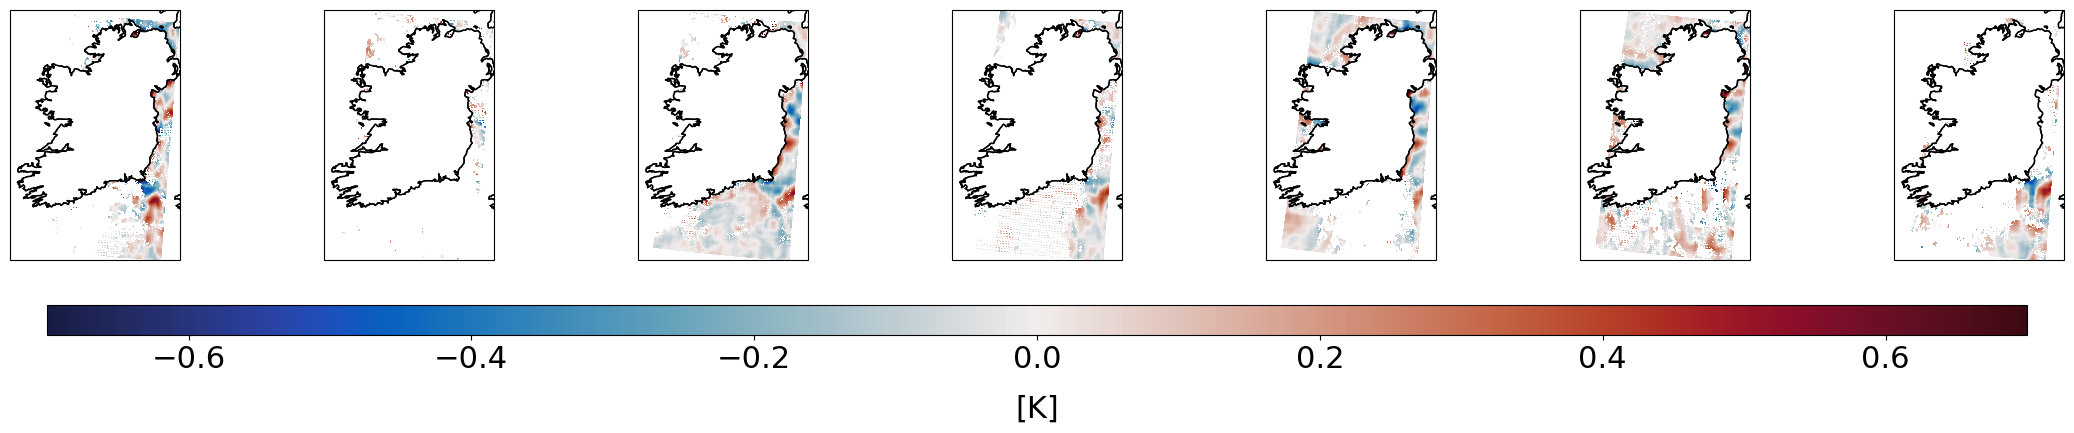

In [11]:
import cmocean as cmo
coords = datamodule.test_ds.get_coords()
m, s = [-0.015420883207237286,0.4562528584789277]
solver_steps = torch.stack(out[1],dim=0).detach().cpu().numpy()*s+m
solver_steps[0] = test_batch.input.detach().cpu().numpy()*s+m
# datamodule.train_ds[0].input has shape (15, 240, 240)
#plt.figure(figsize=(30,20))
p = xr.Dataset(data_vars={'sst':(('time','lat','lon'),test_batch.input[0,:,:,:].detach().cpu().numpy()*s+m)},
           coords={'time':np.arange(7),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='time',col_wrap=7,
                                                   vmin=-.7, vmax=.7,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)
mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-3)

for ax in p.axes.flat:
    ax.set_title('')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    #ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon), 
                   np.max(coords[2*k].lon), 
                   np.min(coords[2*k].lat), 
                   np.max(coords[2*k].lat)], crs=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1)

/tmp/ipykernel_2610785/782495030.py:18: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_2610785/782495030.py:25: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


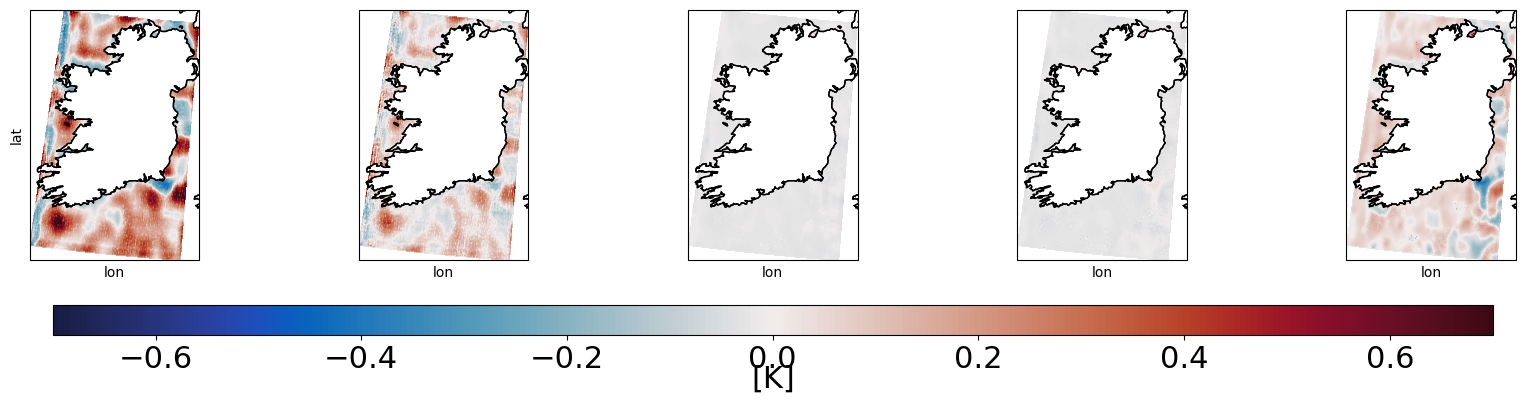

In [12]:
coords = datamodule.test_ds.get_coords()
m, s = [-0.015420883207237286,0.4562528584789277]
solver_steps = torch.stack(out[1],dim=0).detach().cpu().numpy()*s+m
#solver_steps[0] = test_batch.input.detach().cpu().numpy()*s+m

p = xr.Dataset(data_vars={'sst':(('steps','lat','lon'),solver_steps[[0,1,4,8,14],0,6,:,:])},
           coords={'steps':np.arange(5),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='steps',col_wrap=5,
                                                   vmin=-.7, vmax=.7,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)

mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-2)

plt.subplots_adjust(wspace=.3,hspace=.3)
for ax in p.axes.flat:
    ax.set_title('')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    #ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon), 
                   np.max(coords[2*k].lon), 
                   np.min(coords[2*k].lat), 
                   np.max(coords[2*k].lat)], crs=ccrs.PlateCarree())

In [17]:
out = []
for i in range(10):
    print(i)
    tmp = solver_VAE(test_batch_)[0]
    out.append(tmp)
    tmp = None
out = torch.stack(out,dim=0)

0
1
2
3
4
5
6
7
8
9
10
11


RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 79.14 GiB total capacity; 68.53 GiB already allocated; 11.62 MiB free; 71.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

/tmp/ipykernel_2610785/1808623901.py:16: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  mappable = p.axes[0][0].collections[0]
/tmp/ipykernel_2610785/1808623901.py:22: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


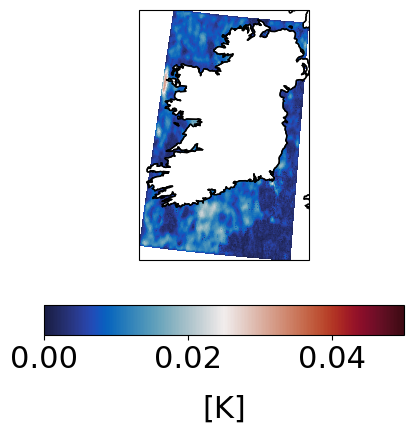

In [21]:
import cmocean as cmo
coords = datamodule.test_ds.get_coords()
# datamodule.train_ds[0].input has shape (15, 240, 240)
#plt.figure(figsize=(30,20))
p = xr.Dataset(data_vars={'sst':(('time','lat','lon'),torch.std(out*s+m,dim=0)[0,[6],:,:].detach().cpu().numpy())},
           coords={'time':np.arange(1),
                   'lon':coords[2*k].lon,
                   'lat':coords[2*k].lat}).sst.plot(transform=ccrs.PlateCarree(),
                                                   col='time',col_wrap=1,
                                                   vmin=0, vmax=0.05,
                                                   cmap=cmo.cm.balance,
                                                   #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'], 
                                                   #subplot_kws={'projection': ccrs.Orthographic(0, 45)})
                                                   subplot_kws={'projection': map_proj},
                                                   add_colorbar=False)
mappable = p.axes[0][0].collections[0]
cax = plt.axes([0.05, -0.2, 0.9, 0.1])
cbar1 = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar1.ax.tick_params(labelsize=22,axis="both")
cbar1.ax.set_title("[K]",fontsize=22,y=-3)

for ax in p.axes.flat:
    ax.set_title('')
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black',facecolor="white")
    ax.set_global()
    #ax.gridlines(draw_labels=True)
    ax.set_extent([np.min(coords[2*k].lon), 
                   np.max(coords[2*k].lon), 
                   np.min(coords[2*k].lat), 
                   np.max(coords[2*k].lat)], crs=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.1)